### IBM AutoAI-SDK Auto-Generated Notebook v1.11.12

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview.
-  pipeline evaluation.
-  pipeline deployment and webservice scoring

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)     
    a.  [Connection to WML](#wml_connection)        
    b.  [Defined variables from experiment](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance and training details](#get_hist_and_train)      
    b.  [Get pipeline](#get_pipeline)      
    c.  [Preview pipeline model to python code representation](#preview_model_to_python_code)      
    d.  [Visualize pipeline](#visualize_pipeline)      
    e.  [Reading training and holdout](#train_holdout_read)      
    f.  [Test pipeline model locally](#test_model)      
3.	[Pipeline refinery](#refinery)      
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deployment and scoring](#scoring)      
    a.  [Deployment creation](#deployment)      
    b.  [Scoring of webservice](#online_scoring)      
    c.  [Deleting deployment](#delete_deployment)      
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `watson-machine-learning-client` uninstallation of the old client
 - `watson-machine-learning-client-V4` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` installation/downgrade 
 - `xgboost` installation/downgrade

In [1]:
!pip uninstall watson-machine-learning-client -y

In [2]:
!pip install -U watson-machine-learning-client-V4

Requirement already up-to-date: watson-machine-learning-client-V4 in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.99)


In [3]:
!pip install -U autoai-libs

Requirement already up-to-date: autoai-libs in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.10.12)


In [4]:
!pip install -U lightgbm==2.2.3

Requirement already up-to-date: lightgbm==2.2.3 in /opt/conda/envs/Python36/lib/python3.6/site-packages (2.2.3)


In [5]:
!pip install -U xgboost==0.90

Requirement already up-to-date: xgboost==0.90 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.90)


<a id="wml_connection"></a>
### Connect to WML
**Action:** Next you will need credentials for Watson Machine Learning:
 - go to [Cloud catalog resources list](https://cloud.ibm.com/resources)
 - click on Services and chose Machine Learning service. Once you are there
 - click the **Service Credentials** link on the left side of the screen
 - click to expand specific credentials name.
 - copy and paste your WML credentials into the cell below

*Take in mind that WML Service instance should be the same as used to generate this notebook.*

In [6]:
wml_credentials = {
  "apikey": "f6zO7d5DGfwLaRA2zCAqpXUSOchN518W5bpJOgKbj3Gv",
  "iam_apikey_description": "Auto-generated for key 7d1c4014-ca4d-445f-ba95-d329914e14a4",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/6447e37a94664718a62d396c9acda41c::serviceid:ServiceId-0dddd569-1c82-4eea-9fe7-af521a17b501",
  "instance_id": "08e11675-62a8-41d0-9b05-81cc077ea313",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

<a id="variables_definition"></a>
### Defined variables from experiment

This cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [7]:
run_id = 'a833e26d-4506-46b2-9e60-93639151a5ca'
pipeline_name = 'Pipeline_3'
scorer = 'neg_root_mean_squared_error'
target_label_name = 'Life expectancy '

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance and training details

The next cell contains code for retrieving fitted optimizer.

In [8]:
from watson_machine_learning_client.experiment import AutoAI

experiment = AutoAI(wml_credentials)
optimizer = experiment.runs.get_optimizer(run_id)

<a id="get_pipeline"></a>
### Get pipeline

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [9]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [10]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import ColumnSelector
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.operators import make_pipeline
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.operators import make_union
from lale.lib.autoai_libs import NumpyPermuteArray
from lale.lib.autoai_libs import TA2
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from lale.lib.autoai_libs import TA1
import autoai_libs.cognito.transforms.textras_methods
from lale.lib.sklearn import ExtraTreesRegressor

column_selector = ColumnSelector(columns_indices_list=[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 19, 20])
numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 6, 9, 11])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'float_int_num', 'float_int_num', 'float_int_num'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], [float('nan')], [float('nan')], [float('nan')]])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[float('nan')])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), 100001, 100001, 100001], known_values_list=[[147001224856526974832278065163338061039, 260699343329343420250263481462496204476, 116118337134451577549341133852425958601, 46751138953470937772175891669486975303, 329516381543508488967110039675080977027, 70733328421398721497322766143577833507, 212739582897968815372252009904290618533, 90734833563168770064755926536533285101, 202797882335700325897457917503166655784, 150820500098510481813415427383903426184, 145877534885301049267215912567317643431, 146042710492699183527689945925558913871, 329038285037642035448290014465150269573, 66569159131289518452679319382561400624, 134599758546830170946961007508765805273, 143673223417367409597806890422171484583, 43514824087351888171828013500097472829, 210599618041562972070936847789988036902, 306190046251434926279001033014007339831, 257386254094586331070623087230906766309, 200250612019127811152210464978673413843, 144662901196442033596517283743993697168, 88162585471654943964443952621227739261, 70896928478956771791708447884634167142, 2166848313003821530343725614844784907, 53840538962412723146725100117737849769, 53783522580166489497692045789692745562, 137433131769320511325160171555965548550, 9011956582324283455402195937934571568, 100867498053965421926683001219366720175, 90871431497902965602878565155781788327, 226182883875297231091414872587504708035, 298029156183361964131144349277717108303, 61669071338325875054847411897241946095, 231725186024138418821343173350662523706, 317953072729355616170708786288199146493, 88003295792748799025659169863539916864, 303846827209572410860542030980915489108, 117650741643591557067501287780038143451, 114382657829694160542291743577444141255, 68843515830881058478891148667609669513, 311265945460282885639496306569138650308, 66336313050842184927485246200945105096, 6278551754760904136723792210512775816, 264133828541403902365817922285691706663, 237672356660114685772687796104882206514, 88072156716790939851742967815210212361, 191655845835528033820508997679585417644, 135810150341533680846069152682895393814, 102836150724757230410725033869934678966, 301866387735507500246434251973708559904, 310276828594327150016809604736391170592, 217391883616977436792885859915168492233, 268223368701600857288201315803513880319, 158620802268026701334269447796294077650, 301204325272916423115124616267654497404, 113902216111633146684341394651838421184, 148167959092401686537001101821165870815, 4037797258022100113842494415863664385, 336187489452407039394791603109816227725, 301285256860312455785994867529604192476, 312173900060238937270521904129323847731, 288027277195630534052428568134696149071, 307384067113960046097974087241019802729, 142816848122656347891616720396877128120, 92639897809877101370166021321317973767, 197447874931603182353652347006218732046, 189153405801674659090813067540413446960, 60344653786708434424191955208148258744, 275547366651759454322811788273436150404, 245291117150675811910476227597757516612, 324534391971762113271501167168766491614, 332939221964977781373840866644320659361, 243990464967881250218096721123374832934, 166412482558944353431194533546670637099, 93418832550626031277006178804300582857, 100868194317926940154051177041401533500, 120809162883000100157782458277608403667, 9159657324535943692931225915386977603, 120069515845204766982513747293765138127, 21308572128415219572389994084010018174, 35708372757894372072386266404379628553, 111185081072713903471978902125976427675, 147055629285626963240164699118015634288, 164962277741819786224663597464248928300, 197516484511383225722150740031787721089, 112016882230000284908020292505580427074, 6939489273329044312136123259432836815, 125332411340882160702044993227052216001, 172336042347945209501542869303082370283, 213503579105731811632182799702211304277, 239759361309886661677188287055236569981, 310518635096297103991571280952035141839, 133154737170846526745897437786271419044, 154416530328912057507365665258369549472, 288469045950546730190193078847193098970, 8489659610198709691142666728949069345, 241570600237737391575071415960427031848, 149654325505539066448015487336620561262, 83815552068744036481632236478853198433, 130447722156717403042775871542217532557, 309775428472593936764999908740771513965, 194433639230741600743331401076929663747, 287105209433439742579762737349674202805, 10570423956451357204371014450649656715, 188392261694543715233845217008066282321, 313379486574562434335207500262629208144, 249118345345366939574908646319607340890, 104442926034210402647486596299287548193, 102735254899278162311633387159256797168, 221751288586957193672400042500503422193, 44527298243131759828592721352141504605, 140836680648177864032144374895547548555, 170055084650409142322787336947434585942, 221302440909767410133343183967811973171, 262018014442368137572517042065553566541, 79743781199220374265767606077128191664, 254125374157180781180627978456850690728, 124301341133029451973017544367696533615, 284086970395620794029446821886845268390, 37840028582551292843841493013743517702, 246455200204341180287241602094154852031, 143453842366453184196547081438629502439, 327575913974710642489356558011361228625, 152944767264824636164907421713899865093, 176501628211118575758228455305804789656, 159313682139237172887381305992317026546, 197432136167945168220584321832631475989, 311629718944900440174423894212659294477, 165862387931083018136327956233088224545, 200992098551941933530619672502718259277, 13211283604650144315074545178289956239, 16601616560883432713160786478393331488, 10416612163005955661073717074093387062, 209347361968514815068844481488500366786, 279050323757951516155403396511033587716, 264459266514432677140218732179794369611, 11137867482523875936741238848881502531, 229483763589706052603319193282544725320, 244856816748827073573575820596953224849, 204069336107114946409550070958759494527, 63755669758532025214039349785250391083, 280323114304267706123307379055557896439, 201141749708336609603825854380051921870, 92455594258272590489960197032004391800, 181624327439045060956820224446253696114, 189246905584152577259182499180590580, 219924701173169887305713158245281315340, 194193646109240189407775880338662800887, 266654382484335115128215294640512574736, 13808061030652180811345778413029230717, 192066837354053545233955008532086692251, 318124203124418465236696385800557006393, 154551519819035509041533706282186084707, 133278040923567948891376187569301318446, 329872229251628136616936033528845404207, 267113292827397478038595255593918245163, 78177890450179508590854891703042317668, 159821081429796844717628326887647430719, 241470080325170968009603514017433045249, 21534237697347747059400795433402612858, 331485374723644292946494024341588888803, 13488206953706492194337998636897954158, 40481344139765028445355540856481018998, 294240741554643331939894211760785349296, 132374248062000760689647888900256269745, 285590841995412959284881794170248825349, 45343673659765490367261512791957359538, 326790586085090417519839246359297909943, 111259412569678040964004624811056505841, 319179760373270718270012367276983387589, 190656778724682718055384399764338191549, 274586769213526317171775513233049188730, 65014702474602264403928616790135130394, 41300458528712720009228826094222395870, 155901190345235079326433256810539957264, 213527539495502148379722298681646646713, 337664892250511449878491415602564465320, 149187898203650094159705085163227929822, 192946003755599889927910624585418472243, 151926378701363846636626095694661523383, 234826980371610571253952539720242605948, 209109830453134779187508710962259670256], [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 14.0, 15.0, 17.0, 18.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0], [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 23.0, 24.0, 26.0, 31.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0], [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 19.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
pipeline_0 = make_pipeline(numpy_column_selector_0, compress_strings, numpy_replace_missing_values_0, numpy_replace_unknown_values, boolean2float(), cat_imputer, cat_encoder, float32_transform())
numpy_column_selector_1 = NumpyColumnSelector(columns=[2, 3, 4, 5, 7, 8, 10, 12, 13, 14, 15, 16])
float_str2_float = FloatStr2Float(dtypes_list=['float_int_num', 'int_num', 'float_num', 'float_num', 'int_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num', 'float_num'], missing_values_reference_list=[float('nan')])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[float('nan')])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
pipeline_1 = make_pipeline(numpy_column_selector_1, float_str2_float, numpy_replace_missing_values_1, num_imputer, opt_standard_scaler, float32_transform())
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 6, 9, 11, 2, 3, 4, 5, 7, 8, 10, 12, 13, 14, 15, 16])
ta2 = TA2(fun=np.add, name='sum', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Country', 'Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', 'Income composition of resources', 'Schooling'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 17), additional_col_count_to_keep=15, ptype='regression')
ta1 = TA1(fun=autoai_libs.cognito.transforms.textras_methods.sigmoid, name='sigmoid', datatypes=['numeric'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Country', 'Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', 'Income composition of resources', 'Schooling', 'sum(Country__Adult Mortality)', 'sum(Adult Mortality__Alcohol)', 'sum(Adult Mortality__Hepatitis B)', 'sum(Adult Mortality__Total expenditure)', 'sum(Adult Mortality__ HIV/AIDS)', 'sum(Adult Mortality__Income composition of resources)', 'sum(Adult Mortality__Schooling)', 'sum(Alcohol__Adult Mortality)', 'sum(Hepatitis B__Adult Mortality)', 'sum(Total expenditure__Adult Mortality)', 'sum( HIV/AIDS__Adult Mortality)', 'sum(Income composition of resources__Adult Mortality)', 'sum(Income composition of resources__Schooling)', 'sum(Schooling__Adult Mortality)', 'sum(Schooling__Income composition of resources)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 17), additional_col_count_to_keep=15, ptype='regression')
extra_trees_regressor = ExtraTreesRegressor(bootstrap=True, n_jobs=4, oob_score=True, random_state=33)
pipeline = make_pipeline(column_selector, union, numpy_permute_array, ta2, fs1_0, ta1, fs1_1, extra_trees_regressor)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


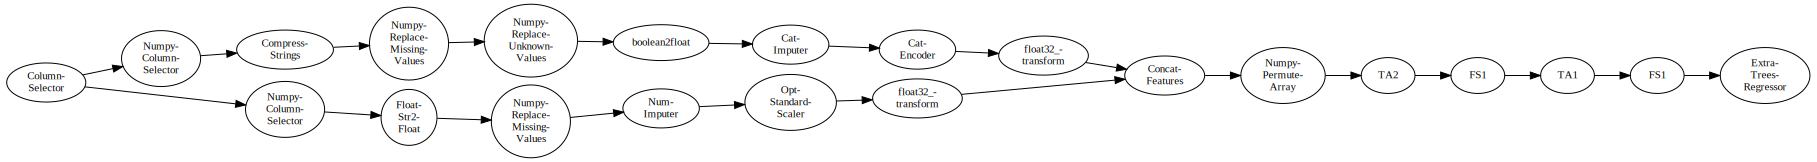

In [11]:
pipeline_model.visualize()

<a id="train_holdout_read"></a>
### Reading training and holdout data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [12]:
training_df, holdout_df = optimizer.get_data_connections()[0].read(with_holdout_split=True)

train_X = training_df.drop([target_label_name], axis=1).values
train_y = training_df[target_label_name].values

test_X = holdout_df.drop([target_label_name], axis=1).values
y_true = holdout_df[target_label_name].values

<a id="test_model"></a>
### Test pipeline model locally
**Note**: you can chose the metric to evaluate the model by your own, this example contains only a basic scenario.

In [13]:
from sklearn.metrics import r2_score

predictions = pipeline_model.predict(test_X)
score = r2_score(y_true=y_true, y_pred=predictions)
print('r2_score: ', score)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<a id="refinery"></a>
## Pipeline refinery and testing (optional)

In this section you will learn how to refine and retrain the best pipeline returned by AutoAI.
It can be performed by:
 - modifying pipeline definition source code
 - using [lale](https://lale.readthedocs.io/en/latest/) library for semi-automated data science

**Note**: In order to run this section change following cells to 'code' cell.

<a id="pipeline_definition"></a>
### Pipeline definition source code
Following cell lets you experiment with pipeline definition in python, e.g. change steps parameters.

It will inject pipeline definition to the next cell.

<a id="lale_library"></a>
### Lale library

**Note**: This is only an exemplary usage of lale package. You can import more different estimators to refine downloaded pipeline model.

#### Import estimators

<a id="decomposition_definition"></a>
#### Pipeline decomposition and new definition
In this step the last stage from pipeline is removed.

<a id="new_optimizer"></a>
#### New optimizer `hyperopt` configuration and training

This section can introduce other results than the original one and it should be used
by more advanced users.

New pipeline is re-trained by passing train data to it and calling `fit` method.

<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="deployment"></a>
### Deployment creation

**Action**: Please change:
 - the pipeline_model to new_pipeline in order to deploy refined pipeline
 - the deployment name

In [ ]:
from watson_machine_learning_client.deployment import WebService

service = WebService(wml_credentials)

service.create(
    experiment_run_id=run_id,
    model=pipeline_model, 
    deployment_name=f'{pipeline_name}_webservice'
    )

Deployment object could be printed to show basic information:

In [ ]:
print(service)

To be able to show all available information about deployment use `.get_params()` method:

In [ ]:
service.get_params()

<a id="online_scoring"></a>
### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [ ]:
predictions = service.score(payload=holdout_df.drop([target_label_name], axis=1).iloc[:10])
predictions

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by `service = WebService(wml_credentials)`
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

<a id="delete_deployment"></a>
### Deleting deployment

You can delete an existing deployment by calling `service.delete()`.

<a id="authors"></a>
### Authors

Licensed Materials - Copyright (C) 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___